## 1. Packages & Parallel Processing Setup

In [ ]:
# Initialize Distributed Workers
using Distributed
if nworkers() == 1
    addprocs(10) # PARAM - adjust number of workers as needed i.e. available CPU cores
end
using Plots
@everywhere using Agents, Random, Statistics

## 2. Agent definition



In [2]:
@everywhere Agents.@agent struct Player(GridAgent{2})
    norm::Int8          # 1 => norm1? true ; 0 => norm2
    payoff::Float64
end

## 3. Model initialization



In [ ]:

@everywhere begin
    function initialize(; M=30, init_norm1=0.20,
        norm1_prosocial_benefit=0.0,
        norm1_coord_benefit=0.0,
        norm1_rarity_cost=0.0)

        space = GridSpaceSingle((M, M); periodic=true)
        properties = Dict(
            :norm1_prosocial_benefit => norm1_prosocial_benefit,
            :norm1_coord_benefit => norm1_coord_benefit,
            :norm1_rarity_cost => norm1_rarity_cost
        )

        model = StandardABM(
            Player, space;
            agent_step!, model_step!,
            properties=properties,
            scheduler=Schedulers.Randomly()
        )

        N = M^2
        n1 = round(Int, init_norm1 * N) # random initalization of norms
        norms = vcat(fill(1, n1), fill(0, N - n1)) # 1 => norm1; 0 => norm2
        shuffle!(norms)
        for s in norms
            add_agent_single!(model; norm=s, payoff=0.0)
        end
        return model
    end
end


## 4. Dynamics - agent_step!

In [4]:
# 
@everywhere begin
    function agent_step!(a, model)
        ags = allagents(model)
        p1 = count(x -> x.norm == 1, ags) / length(ags) # freq of norm1

        prosoc = model.norm1_prosocial_benefit
        coord = model.norm1_coord_benefit
        rarity = model.norm1_rarity_cost

        norm1_payoff = p1 * (1 + prosoc + coord) + (1 - p1) * (1 - rarity) # payoff for norm1
        norm2_payoff = p1 * (1 + prosoc) + (1 - p1)  # payoff for norm2

        a.payoff = (a.norm == 1) ? norm1_payoff : norm2_payoff # update payoff
        return
    end
end


## 5. Dynamics - model_step!

In [5]:
@everywhere begin
    function model_step!(model)
        ids = collect(allids(model))
        shuffle!(ids)

        for id in ids
            a = model[id]
            partner = random_agent(model) # select random partner
            while partner.id == a.id
                partner = random_agent(model)
            end

            Δ = partner.payoff - a.payoff # payoff difference
            prob_copy = 1 / (1 + exp(-Δ)) # Fermi rule 
            if rand() < prob_copy # copy partner's norm if condition met
                a.norm = partner.norm
            end
        end
        return
    end
end


## 6. Helper - running simulation batches

In [21]:
@everywhere begin
    function run_fixedsteps!(model; steps=100)
        for _ in 1:steps
            step!(model, 1)
            f1 = mean(a -> a.norm == 1, allagents(model)) # freq of norm1 used for stopping condition
            (f1 == 0.0 || f1 == 1.0) && break # stop if fixation reached
        end
        return
    end

    function run_trial(; M=30, init_norm1=0.20, # run a single trial
        norm1_prosocial_benefit=0.0,
        norm1_coord_benefit=0.0,
        norm1_rarity_cost=0.0,
        steps=100)
        model = initialize(M=M, init_norm1=init_norm1,
            norm1_prosocial_benefit=norm1_prosocial_benefit,
            norm1_coord_benefit=norm1_coord_benefit,
            norm1_rarity_cost=norm1_rarity_cost)
        run_fixedsteps!(model; steps=steps);
        return mean(a -> a.norm == 1, allagents(model)); # return final freq of norm1
    end
end

## 7. Parameter sweep settings and simulate

In [23]:
# Simulat and plot 
# Adjust parameters here 
coord = 1.0   # norm1_coord_benefit - adjust as needed
rarity = 0.5   # norm1_rarity_cost - adjust as needed
prosocial = 1.0   # norm1_prosocial_benefit - adjust as needed
p_star = rarity / (coord + rarity)  # critical initial frequency

p0_vals = collect(0.18:0.01:0.50) # range of initial frequencies - adjust as needed
pairs = [(p0, i) for p0 in p0_vals for i in 1:100] # 100 trials per initial freq - adjust as needed

finals = pmap(pairs) do (p0, _)
    run_trial(M=31, # adjust M as needed
        init_norm1=p0,
        norm1_prosocial_benefit=prosocial,
        norm1_coord_benefit=coord,
        norm1_rarity_cost=rarity,
        steps=100); # adjust steps as needed
end;


## 7. Build and display plot

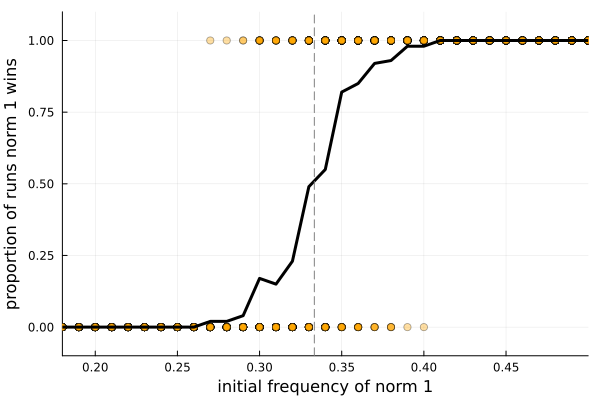

In [8]:

by_p0 = Dict{Float64,Vector{Float64}}(p0 => Float64[] for p0 in p0_vals)
for (i, (p0, _)) in enumerate(pairs)
    push!(by_p0[p0], finals[i])
end
prop_win = [mean(by_p0[p0] .>= 0.99) for p0 in p0_vals] # 0.99 threshold for norm1 fixation, can adjust as needed

#  scatter data
x_dots = []
y_dots = []
for p0 in p0_vals, v in by_p0[p0]
    push!(x_dots, p0)
    push!(y_dots, v >= 0.99 ? 1.0 : 0.0) # 0.99 threshold for norm1 fixation, can adjust as needed
end

# plot
plt = scatter(x_dots, y_dots; color=:orange, alpha=0.2, ms=4, label="")
plot!(plt, p0_vals, prop_win; color=:black, lw=3, label="")
vline!(plt, [p_star]; l=:dash, c=:gray, label="")
xlabel!(plt, "initial frequency of norm 1")
ylabel!(plt, "proportion of runs norm 1 wins")
ylims!(plt, -0.1, 1.1)
xlims!(plt, minimum(p0_vals), maximum(p0_vals))
display(plt)
